# Auditing Allocative Bias
In this blogpost, I will train a model to predict income based on demographic variables *excluding* sex, and perform audit for gender bias on the model.

## Data Preparation
The data I choose to look into is the PUMS data in for Illinois in 2019. 

In [1]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "IL"

data_source = ACSDataSource(survey_year='2019', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)
possible_features=['AGEP', 'SCHL', 'MAR', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR', "PINCP"]
acs_data[possible_features].head()

,AGEP,SCHL,MAR,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR,PINCP
0,19,19.0,5,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,6.0,0.0
1,18,18.0,5,2,NaN,1,3.0,4.0,4,1,2,2,2.0,2,1,6.0,800.0
2,22,16.0,5,2,NaN,1,3.0,1.0,2,1,2,2,2.0,1,1,4.0,35000.0
3,64,16.0,5,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,6.0,0.0
4,53,16.0,5,2,NaN,5,1.0,4.0,1,2,2,2,2.0,1,1,1.0,31200.0


I would like to predict whether an individual's income is over $50K based on all the variables in <code>possible_features</code> except for sex. I will create a feature matrix, a label vector, and a group label vector using the relevant variables, and split them into training data and test data.

In [2]:
features_to_use = [f for f in possible_features if f not in ["PINCP", "SEX"]]

IncomeProblem = BasicProblem(
    features=features_to_use,
    target='PINCP',
    target_transform=lambda x: (x > 50000) * 1, # transform income variable into binary category
    group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = IncomeProblem.df_to_numpy(acs_data)

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

### Basic Descriptives
Before training any models, I will first explore the basic descriptives of the dataset. 

In [28]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

In [4]:
size = len(df)
size

100005

There are 100005 individuals in the dataset. 

In [5]:
(df["label"] == 1).sum()/size

0.25900704964751764

Around 25.9% of these individuals earn over $50K. 

In [6]:
df.groupby("group").size()

group
1    49135
2    50870
dtype: int64

49,135 of these individuals are male and 50,870 are female.

In [7]:
df.groupby("group")["label"].mean().reset_index()


,group,label
0,1,0.326712
1,2,0.193611


Around 32.7% of male individuals in the dataset has income over 50k dollars, but only 19.4% of women has income over $50k. 

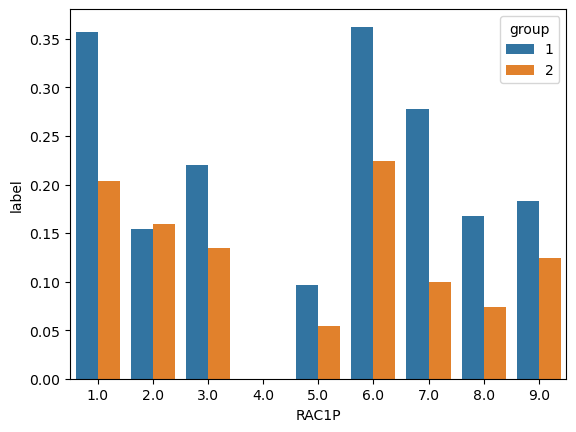

In [8]:
import seaborn as sns
proportions = df.groupby(["group", "RAC1P"])["label"].mean().reset_index()
ax = sns.barplot(data = proportions, x = "RAC1P", y = "label", hue = "group")

It seems that for almost all race groups, the proportion of men with income over $50k is greater than that of women. The only exception is African Americans, for whom this proportion doesn't differ very much across sex. 

## Training the model
I choose to use a decision tree classifier for my prediction. I will use cross-validation to find out the best max depth for the model. 

Best cv score =  0.8123893805309734
Best max depth =  8


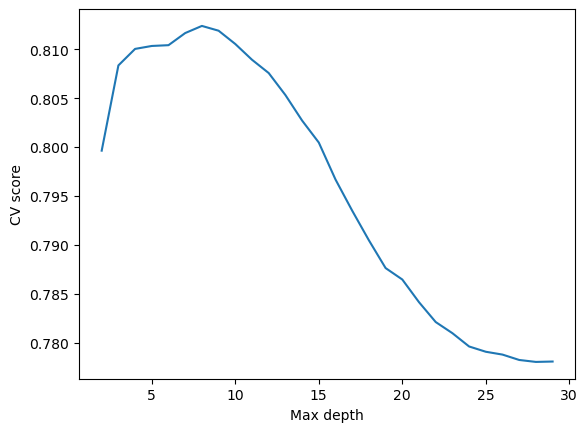

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

cv_max = 0
best_depth = 0
cvs = []

for d in range(2, 30):
    # fit model
    DTC = DecisionTreeClassifier(max_depth = d)
    DTC.fit(X_train, y_train)

    # cross-validation
    cv_scores = cross_val_score(DTC, X_train, y_train, cv = 5)
    cv_mean = cv_scores.mean()
    cvs.append(cv_mean)

    # update best cv score and best degree
    if cv_mean > cv_max:
        cv_max = cv_mean
        best_depth = d

print("Best cv score = ", cv_max)
print("Best max depth = ", best_depth)

# draw a line chart for cv scores at varying degrees
import matplotlib.pyplot as plt
fig = plt.plot(range(2, 30), cvs)
xlab = plt.xlabel("Max depth")
ylab = plt.ylabel("CV score")

As shown by the graph, the best performance is reached at a max depth of 8. 

## Auditing the Model
Next, I will use the model on the test data and perform an audit for bias.

In [22]:
# train model and predict using test data
DTC = DecisionTreeClassifier(max_depth = best_depth)
DTC.fit(X_train, y_train)
y_pred = DTC.predict(X_test)

### Overall Measures
First, we will take a look at the measures for the whole dataset. 

In [25]:
from sklearn.metrics import confusion_matrix

# get confusion matrix values
cm = confusion_matrix(y_test, y_pred)
TP, FP, FN, TN = cm[0][0], cm[0][1], cm[1][0], cm[1][1]

test_score = DTC.score(X_test, y_test)
PPV = TP / (TP + FP)
FNR = FN / (TP + FN)
FPR = FP / (TN + FP)

print("Overall accuracy = ", test_score)
print("PPV = ", PPV)
print("FNR = ", FNR)
print("FPR = ", FPR)

Overall accuracy =  0.8155747540196784
PPV =  0.9173833584175446
FNR =  0.15262400079439947
FPR =  0.316190084344785


The overall accuracy and PPV show that the model is quite accurate. The FPR is one time higher than the FPR, suggesting that this model is more likely to wrongly predict that someone earns over $50K when they does not in reality, compared to wrongly predict that someone earns less than 50K. 

### By-Group Measures
Then we will compute the same measures by each group (i.e., male and female) and see if there are any differences. 

In [32]:
male = group_test == 1
female = group_test == 2

correct = (y_test == y_pred)

accuracy_male = correct[male].mean()
accuracy_female = correct[female].mean()

accuracy_male, accuracy_female

(0.7849171180042672, 0.8447253433208489)

The accuracy for male and female is similar, and a little higher for female. 

In [34]:
#X_test_df = pd.DataFrame(X_test, columns = [features_to_use])
cm_male = confusion_matrix(y_test[male],y_pred[male])
cm_female = confusion_matrix(y_test[female],y_pred[female])

# male
TP, FP, FN, TN = cm_male[0][0], cm_male[0][1], cm_male[1][0], cm_male[1][1]
PPV_male = TP / (TP + FP)
FNR_male = FN / (TP + FN)
FPR_male = FP / (TN + FP)

# female
TP, FP, FN, TN = cm_female[0][0], cm_female[0][1], cm_female[1][0], cm_female[1][1]
PPV_female = TP / (TP + FP)
FNR_female = FN / (TP + FN)
FPR_female = FP / (TN + FP)

PPV_male, PPV_female

(0.9252971137521222, 0.9110832206989766)

The PPV for male and female is similar too. 

In [35]:
FNR_male, FNR_female

(0.20809548521017124, 0.10175138016371597)

The false negative rate is higher for male than for female. This shows that if a man earns more than $50K, the model is more likely to make a mistake and say he earns less, compared to the same situation for a woman. 

In [36]:
FPR_male, FPR_female

(0.24147393179145432, 0.3987012987012987)

The false positive rate is higher for female than for male. This means that the model is more likely to predict that a woman earns more than $50K when she actually earns less. 

### Bias Measures
Finally, we will calculate the three different bias measures discussed by Chouldechova (2017). 

The first measure is calibration. Good calibration means that a man and a woman who received the same score (in this case, either 0 or 1) have the same probability of earning over $50K. 

In [44]:
# Calibration
print("% positive for male predicted positive = ", y_test[male][y_pred[male] == 1].mean())
print("% positive for female predicted positive = ", y_test[female][y_pred[female] == 1].mean())
print("% positive for male predicted negative = ", y_test[male][y_pred[male] == 0].mean())
print("% positive for female predicted negative = ", y_test[female][y_pred[female] == 0].mean())

% positive for male predicted positive =  0.7585260682085456
% positive for female predicted positive =  0.6012987012987013
% positive for male predicted negative =  0.20809548521017124
% positive for female predicted negative =  0.10175138016371597


The probabilities are around 0.1-0.15 higher for men than for women. It looks like the model is roughly calibrated, but still, there is a slight difference in what the same score means for the two groups. 

## Bikeshare data set
In this section, I train my linear regression model to a bikeshare data set.

In [16]:
# import data
import pandas as pd
from sklearn.model_selection import train_test_split
bikeshare = pd.read_csv("https://philchodrow.github.io/PIC16A/datasets/Bike-Sharing-Dataset/day.csv")

bikeshare.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


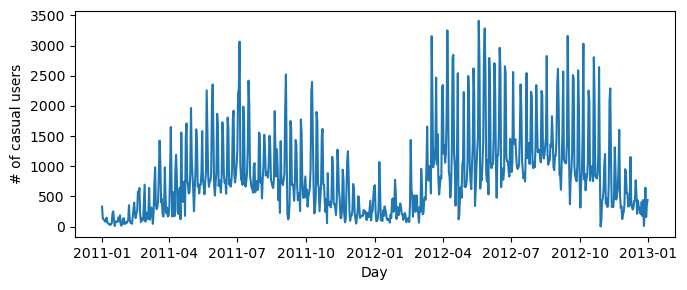

In [17]:
# plot the number of casual users over time
fig, ax = plt.subplots(1, figsize = (7, 3))
ax.plot(pd.to_datetime(bikeshare['dteday']), bikeshare['casual'])
ax.set(xlabel = "Day", ylabel = "# of casual users")
l = plt.tight_layout()

In [18]:
# transforming data
cols = ["casual", 
        "mnth", 
        "weathersit", 
        "workingday",
        "yr",
        "temp", 
        "hum", 
        "windspeed",
        "holiday"]

bikeshare = bikeshare[cols]

bikeshare = pd.get_dummies(bikeshare, columns = ['mnth'], drop_first = "if_binary")
bikeshare

,casual,weathersit,workingday,yr,temp,hum,windspeed,holiday,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
0,331,2,0,0,0.344167,0.805833,0.160446,0,0,0,0,0,0,0,0,0,0,0,0
1,131,2,0,0,0.363478,0.696087,0.248539,0,0,0,0,0,0,0,0,0,0,0,0
2,120,1,1,0,0.196364,0.437273,0.248309,0,0,0,0,0,0,0,0,0,0,0,0
3,108,1,1,0,0.200000,0.590435,0.160296,0,0,0,0,0,0,0,0,0,0,0,0
4,82,1,1,0,0.226957,0.436957,0.186900,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,247,2,1,1,0.254167,0.652917,0.350133,0,0,0,0,0,0,0,0,0,0,0,1
727,644,2,1,1,0.253333,0.590000,0.155471,0,0,0,0,0,0,0,0,0,0,0,1
728,159,2,0,1,0.253333,0.752917,0.124383,0,0,0,0,0,0,0,0,0,0,0,1
729,364,1,0,1,0.255833,0.483333,0.350754,0,0,0,0,0,0,0,0,0,0,0,1


In [19]:
# train-test split
train, test = train_test_split(bikeshare, test_size = .2, shuffle = False)

X_train = train.drop(["casual"], axis = 1)
y_train = train["casual"]

X_test = test.drop(["casual"], axis = 1)
y_test = test["casual"]

In [38]:
# fit and score the model
LR = LinearRegression()
LR.fit(X_train, y_train)
LR.score(X_train, y_train)

0.7318355359284503

The model has a score of 0.73. 

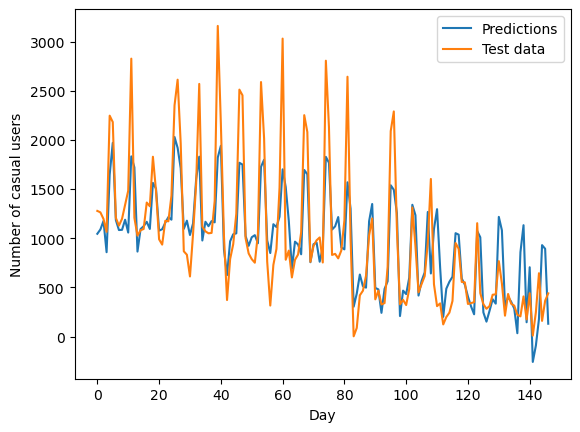

In [29]:
# compute predictions and visualize in comparison to actual test data
y_hat = LR.predict(X_test)

plt.plot(np.arange(len(y_hat)), y_hat, label = "Predictions")
plt.plot(np.arange(len(y_hat)), y_test, label = "Test data")
         
xlab = plt.xlabel("Day")
ylab = plt.ylabel("Number of casual users")
legend = plt.legend() 

It seems that the model does a good job in predicting the general trend in the data -- the overall decreasing number of users and the timing of peaks. However, it tends to underestimate the minimum and maximum values. 

Finally, I will look into the weight vector and see what it reveals about people's preference of when to use bikeshare. 

In [51]:
# compare weight vector to list of features
feature_weights = pd.DataFrame(LR.w[:-1], X_train.columns)
feature_weights

,0
weathersit,-108.371136
workingday,-791.690549
yr,280.586927
temp,1498.715113
hum,-490.100340
windspeed,-1242.800381
holiday,-235.879349
mnth_2,-3.354397
mnth_3,369.271956
mnth_4,518.408753


We can observe a couple of interesting trends from the magnitude and direction of the weights:
1. People use bikeshare more when the weather is nicer -- especially when it is warmer and there is less wind. It is also interesting, though, that the <code>weathersit</code> variable is slightly negatively correlated with the number of users. I wonder what exactly this variable is measuring. 
2. People use bikeshare the most in April and May. This makes sense because weather is the best during this time of the year, while summer is too hot and winter is too cold. 
3. People use bikeshare more on weekends but less on holidays. 